<a href="https://colab.research.google.com/github/EOKELLO/IP-WEEK1-CORE/blob/master/Moringa_Data_Science_Core_W7_Independent_Project_2019_07_Elizabeth_Okello_Python_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Research** **Objective**

1.Predict result of a game between team 1 and team 2, based on who's home and who's away, and on whether or not the game is friendly

2.Figure out from the home team’s perspective if the game is a Win, Lose or Draw (W, L, D)

3.To predict the rank of the teams 

# **Metric for success**

Identify the variables that counted most whether engineering them or dropping the others and creating a model with an accuracy of  above 80% having taken care of all groups

# **The context**

This was done in the context of available fifa data concerning the ELO ranking system and the ammendments that were to be done to ensure fare ranking of participating teams.

# **Experimental design**



Define the question, the metric for success, the context, experimental design taken and the appropriateness of the available data to answer the given question
Expected flow for the assessment:
- Perform your EDA
- Perform any necessary feature engineering
- Check of multicollinearity
- Start building the model
- Cross-validate the model
- Compute RMSE
- Create residual plots for your models, and assess their heteroscedasticity using Bartlett’s test
Perform appropriate regressions on the data including your justification
Challenge your solution by providing insights on how you can make improvements.

# **Appropriateness of the data**

The dataset was appropriate in terms of relevance but for proper predictions more data was needed 

# **Importing Libraries**

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
import warnings
warnings.filterwarnings("ignore")
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [2]:
#loading our datasets
ranking = pd.read_csv('fifa_ranking.csv')
ranking.head()
 

,rank,country_full,country_abrv,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_weighted,three_year_ago_avg,three_year_ago_weighted,confederation,rank_date
0,1,Germany,GER,0.0,57,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
1,2,Italy,ITA,0.0,57,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
2,3,Switzerland,SUI,0.0,50,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
3,4,Sweden,SWE,0.0,55,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
4,5,Argentina,ARG,0.0,51,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CONMEBOL,1993-08-08


In [3]:
#from the adjustements made by fifa we only need the ranking and previous points , rank_date and may be the country_full(team)
#this is because the other variables have been rendered obsolete by being abolished or dimmed not important in the elo ranking system
cols = ['rank','previous_points','country_full','rank_date']
ranking_data = ranking[cols]
ranking_data.head()

,rank,previous_points,country_full,rank_date
0,1,57,Germany,1993-08-08
1,2,57,Italy,1993-08-08
2,3,50,Switzerland,1993-08-08
3,4,55,Sweden,1993-08-08
4,5,51,Argentina,1993-08-08


In [4]:
#from the data description we assume that country full and home team refer to the same thing and for this reson we 
#rename the country_full column to home team to enable merging the two tables
ranking_data.rename(columns={'country_full':'home_team'}, inplace=True)
ranking_data.head()

,rank,previous_points,home_team,rank_date
0,1,57,Germany,1993-08-08
1,2,57,Italy,1993-08-08
2,3,50,Switzerland,1993-08-08
3,4,55,Sweden,1993-08-08
4,5,51,Argentina,1993-08-08


In [5]:
ranking_data.describe()

,rank,previous_points
count,57793.000000,57793.000000
mean,101.628086,332.302926
std,58.618424,302.872948
min,1.000000,0.000000
25%,51.000000,56.000000
50%,101.000000,272.000000
75%,152.000000,525.000000
max,209.000000,1920.000000


from the above table we can see that the previous points has a mean of 332 where it deviates by 30% which means there is lots of variation in previous points between the various participating teams.

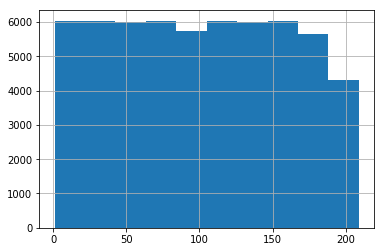

In [6]:
ranking_data['rank'].hist()

From the above image we see data is not normally distributed so we cannot perform many statistical operations on this data.

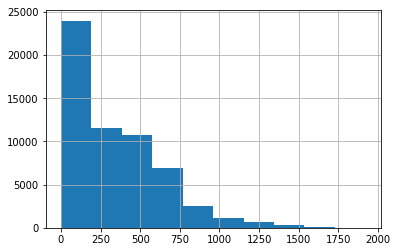

In [7]:
ranking_data['previous_points'].hist()

the datapoints on the column for preivous points is skewed to the right

In [8]:
#check the dataset size
ranking_data.shape

(57793, 4)

In [9]:
#check for missing values
ranking_data.isnull().sum()

rank               0
previous_points    0
home_team          0
rank_date          0
dtype: int64

In [10]:
#loading the results data
results = pd.read_csv('results.csv')
results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


In [11]:
#check size of the dataset
results.shape

(40839, 9)

In [12]:
#check for missing values
results.isnull().sum()

date          0
home_team     0
away_team     0
home_score    0
away_score    0
tournament    0
city          0
country       0
neutral       0
dtype: int64

In [13]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40839 entries, 0 to 40838
Data columns (total 9 columns):
date          40839 non-null object
home_team     40839 non-null object
away_team     40839 non-null object
home_score    40839 non-null int64
away_score    40839 non-null int64
tournament    40839 non-null object
city          40839 non-null object
country       40839 non-null object
neutral       40839 non-null bool
dtypes: bool(1), int64(2), object(6)
memory usage: 2.5+ MB


In [14]:
#we drop the columns that we dont need eg city and country.
results.drop(['city','country',], axis=1, inplace=True)
results.head()

,date,home_team,away_team,home_score,away_score,tournament,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,False
1,1873-03-08,England,Scotland,4,2,Friendly,False
2,1874-03-07,Scotland,England,2,1,Friendly,False
3,1875-03-06,England,Scotland,2,2,Friendly,False
4,1876-03-04,Scotland,England,3,0,Friendly,False


In [0]:
#looking at the datatypes lets convert the dates into the correct date types
ranking_data['rank_date'] = pd.to_datetime(ranking_data['rank_date'], errors='coerce')
results['date'] = pd.to_datetime(results['date'], errors='coerce')

In [16]:
#we confirm whether this has been done successfully
ranking_data.dtypes


rank                        int64
previous_points             int64
home_team                  object
rank_date          datetime64[ns]
dtype: object

In [17]:
results.dtypes

date          datetime64[ns]
home_team             object
away_team             object
home_score             int64
away_score             int64
tournament            object
neutral                 bool
dtype: object

In [0]:
#since we want to use only the relevant data we will spilt the dates into year month and later drop 
#the years before 1993 and after the period 2018 when the system stopped being in effect waiting the pending 
#updates
#separating the year and month from the date columns in both datasets.
results['year']=results['date'].dt.year
results['month']=results['date'].dt.month
ranking_data['year']=ranking_data['rank_date'].dt.year
ranking_data['month']=ranking_data['rank_date'].dt.month

In [19]:
#check if this was done successfully
results.head(2)

,date,home_team,away_team,home_score,away_score,tournament,neutral,year,month
0,1872-11-30,Scotland,England,0,0,Friendly,False,1872,11
1,1873-03-08,England,Scotland,4,2,Friendly,False,1873,3


In [20]:
#check if this was done successfully
ranking_data.head(2)

,rank,previous_points,home_team,rank_date,year,month
0,1,57,Germany,1993-08-08,1993,8
1,2,57,Italy,1993-08-08,1993,8


In [0]:
#if we are to include the ranking in our training we drop the dates before the rankings began and after 
#the stop of implementing
results=results[results['date']>='1993-08-08']
results=results[results['date']<= '2018-06-07']

In [22]:
#this has been done successfully as when we look at the shape of the datset it has reduced
results.shape

(21919, 9)

In [23]:
ranking_data.head()

,rank,previous_points,home_team,rank_date,year,month
0,1,57,Germany,1993-08-08,1993,8
1,2,57,Italy,1993-08-08,1993,8
2,3,50,Switzerland,1993-08-08,1993,8
3,4,55,Sweden,1993-08-08,1993,8
4,5,51,Argentina,1993-08-08,1993,8


In [24]:
#we now want to merge the two tables results and ranking_data on the home team
merged = pd.merge(results,ranking_data, how='left',on=['home_team', 'year', 'month'])
merged.head()

,date,home_team,away_team,home_score,away_score,tournament,neutral,year,month,rank,previous_points,rank_date
0,1993-08-08,Bolivia,Uruguay,3,1,FIFA World Cup qualification,False,1993,8,59.0,13.0,1993-08-08
1,1993-08-08,Brazil,Mexico,1,1,Friendly,False,1993,8,8.0,55.0,1993-08-08
2,1993-08-08,Ecuador,Venezuela,5,0,FIFA World Cup qualification,False,1993,8,35.0,23.0,1993-08-08
3,1993-08-08,Guinea,Sierra Leone,1,0,Friendly,False,1993,8,65.0,23.0,1993-08-08
4,1993-08-08,Paraguay,Argentina,1,3,FIFA World Cup qualification,False,1993,8,67.0,22.0,1993-08-08


In [25]:
#now lets rename the rank to home team rank
merged.rename(columns={'rank':'home_team_rank'}, inplace=True)
merged.head()

,date,home_team,away_team,home_score,away_score,tournament,neutral,year,month,home_team_rank,previous_points,rank_date
0,1993-08-08,Bolivia,Uruguay,3,1,FIFA World Cup qualification,False,1993,8,59.0,13.0,1993-08-08
1,1993-08-08,Brazil,Mexico,1,1,Friendly,False,1993,8,8.0,55.0,1993-08-08
2,1993-08-08,Ecuador,Venezuela,5,0,FIFA World Cup qualification,False,1993,8,35.0,23.0,1993-08-08
3,1993-08-08,Guinea,Sierra Leone,1,0,Friendly,False,1993,8,65.0,23.0,1993-08-08
4,1993-08-08,Paraguay,Argentina,1,3,FIFA World Cup qualification,False,1993,8,67.0,22.0,1993-08-08


In [0]:
#from the ranking data we pull out the away team info by renaming the home team to away team
ranking_data.rename({'home_team': 'away_team'},axis=1, inplace=True)

In [27]:
#check if this is done successfully
ranking_data.head()

,rank,previous_points,away_team,rank_date,year,month
0,1,57,Germany,1993-08-08,1993,8
1,2,57,Italy,1993-08-08,1993,8
2,3,50,Switzerland,1993-08-08,1993,8
3,4,55,Sweden,1993-08-08,1993,8
4,5,51,Argentina,1993-08-08,1993,8


In [0]:
#we now want to bring the away team rank into the merged table as ranking information is key in our project
final = pd.merge(merged,ranking_data, how='left', on=['away_team', 'year', 'month'])

In [29]:
final.head()

,date,home_team,away_team,home_score,away_score,tournament,neutral,year,month,home_team_rank,previous_points_x,rank_date_x,rank,previous_points_y,rank_date_y
0,1993-08-08,Bolivia,Uruguay,3,1,FIFA World Cup qualification,False,1993,8,59.0,13.0,1993-08-08,22.0,47.0,1993-08-08
1,1993-08-08,Brazil,Mexico,1,1,Friendly,False,1993,8,8.0,55.0,1993-08-08,14.0,42.0,1993-08-08
2,1993-08-08,Ecuador,Venezuela,5,0,FIFA World Cup qualification,False,1993,8,35.0,23.0,1993-08-08,94.0,4.0,1993-08-08
3,1993-08-08,Guinea,Sierra Leone,1,0,Friendly,False,1993,8,65.0,23.0,1993-08-08,86.0,16.0,1993-08-08
4,1993-08-08,Paraguay,Argentina,1,3,FIFA World Cup qualification,False,1993,8,67.0,22.0,1993-08-08,5.0,51.0,1993-08-08


In [30]:
#we rename he column rank in the final to away team rank
final.rename(columns={'rank':'away_team_rank','previous_points_x':'home_previous_points','rank_date_x':'home_rank_date',
                      'previous_points_y':'away_previous_points','rank_date_y':'away_rank_date'}, inplace=True)
final.head()

,date,home_team,away_team,home_score,away_score,tournament,neutral,year,month,home_team_rank,home_previous_points,home_rank_date,away_team_rank,away_previous_points,away_rank_date
0,1993-08-08,Bolivia,Uruguay,3,1,FIFA World Cup qualification,False,1993,8,59.0,13.0,1993-08-08,22.0,47.0,1993-08-08
1,1993-08-08,Brazil,Mexico,1,1,Friendly,False,1993,8,8.0,55.0,1993-08-08,14.0,42.0,1993-08-08
2,1993-08-08,Ecuador,Venezuela,5,0,FIFA World Cup qualification,False,1993,8,35.0,23.0,1993-08-08,94.0,4.0,1993-08-08
3,1993-08-08,Guinea,Sierra Leone,1,0,Friendly,False,1993,8,65.0,23.0,1993-08-08,86.0,16.0,1993-08-08
4,1993-08-08,Paraguay,Argentina,1,3,FIFA World Cup qualification,False,1993,8,67.0,22.0,1993-08-08,5.0,51.0,1993-08-08


In [0]:
#we want to make the values in our tournament column to have
#Tournament type (World cup, Friendly, Other)
#We create a function to lay out this
def tournament(match):
  if match == 'FIFA World Cup qualification':
    return 'worldcup'
  if match == 'Friendly':
    return 'Friendly'
  else:
    return 'other'

In [0]:
final['match']=final['tournament'].apply(lambda x: tournament(x))

In [33]:
final.head()

,date,home_team,away_team,home_score,away_score,tournament,neutral,year,month,home_team_rank,home_previous_points,home_rank_date,away_team_rank,away_previous_points,away_rank_date,match
0,1993-08-08,Bolivia,Uruguay,3,1,FIFA World Cup qualification,False,1993,8,59.0,13.0,1993-08-08,22.0,47.0,1993-08-08,worldcup
1,1993-08-08,Brazil,Mexico,1,1,Friendly,False,1993,8,8.0,55.0,1993-08-08,14.0,42.0,1993-08-08,Friendly
2,1993-08-08,Ecuador,Venezuela,5,0,FIFA World Cup qualification,False,1993,8,35.0,23.0,1993-08-08,94.0,4.0,1993-08-08,worldcup
3,1993-08-08,Guinea,Sierra Leone,1,0,Friendly,False,1993,8,65.0,23.0,1993-08-08,86.0,16.0,1993-08-08,Friendly
4,1993-08-08,Paraguay,Argentina,1,3,FIFA World Cup qualification,False,1993,8,67.0,22.0,1993-08-08,5.0,51.0,1993-08-08,worldcup


In [34]:
#we create a column that will hold the values indicating a win,lose or draw and from a home team perspective
#this is computed by getting the difference between home_score and away_score
final['output'] = final['home_score'] - final['away_score']
final.head(1)

,date,home_team,away_team,home_score,away_score,tournament,neutral,year,month,home_team_rank,home_previous_points,home_rank_date,away_team_rank,away_previous_points,away_rank_date,match,output
0,1993-08-08,Bolivia,Uruguay,3,1,FIFA World Cup qualification,False,1993,8,59.0,13.0,1993-08-08,22.0,47.0,1993-08-08,worldcup,2


In [0]:
#we want to also write a function to incorporate whether a match is a win loss or a draw
def output(position):
  if position > 0:
    return 'win'
  if position < 0:
    return 'loss'
  elif position == 0:
    return 'draw'
    

In [36]:
#applying the function
final['position']=final['output'].apply(lambda x: output(x))
final.head(2)

,date,home_team,away_team,home_score,away_score,tournament,neutral,year,month,home_team_rank,home_previous_points,home_rank_date,away_team_rank,away_previous_points,away_rank_date,match,output,position
0,1993-08-08,Bolivia,Uruguay,3,1,FIFA World Cup qualification,False,1993,8,59.0,13.0,1993-08-08,22.0,47.0,1993-08-08,worldcup,2,win
1,1993-08-08,Brazil,Mexico,1,1,Friendly,False,1993,8,8.0,55.0,1993-08-08,14.0,42.0,1993-08-08,Friendly,0,draw


In [0]:
#for us to perform machine learning we have to concert categorical data to numericals so we assign dummy variables
#as below and combine with the dataset
dummy = pd.get_dummies(final['match'])
final=pd.concat([final, dummy], axis=1)

In [0]:
#we now drop the columns that we dont need for modelling like the date,tournament,year,month,home_rank_date,away_rank_date,out
final.drop(['date','away_team','home_team','tournament','year','month','home_rank_date','away_rank_date'], axis=1, inplace=True)


In [39]:
final.head()

,home_score,away_score,neutral,home_team_rank,home_previous_points,away_team_rank,away_previous_points,match,output,position,Friendly,other,worldcup
0,3,1,False,59.0,13.0,22.0,47.0,worldcup,2,win,0,0,1
1,1,1,False,8.0,55.0,14.0,42.0,Friendly,0,draw,1,0,0
2,5,0,False,35.0,23.0,94.0,4.0,worldcup,5,win,0,0,1
3,1,0,False,65.0,23.0,86.0,16.0,Friendly,1,win,1,0,0
4,1,3,False,67.0,22.0,5.0,51.0,worldcup,-2,loss,0,0,1


In [0]:
#convert the neutral column values to numericals and combine with table
dummy_2= pd.get_dummies(final['neutral'])
final=pd.concat([final,dummy_2], axis=1)

In [41]:
#check whether this was successfully done
final.head()

,home_score,away_score,neutral,home_team_rank,home_previous_points,away_team_rank,away_previous_points,match,output,position,Friendly,other,worldcup,False,True
0,3,1,False,59.0,13.0,22.0,47.0,worldcup,2,win,0,0,1,1,0
1,1,1,False,8.0,55.0,14.0,42.0,Friendly,0,draw,1,0,0,1,0
2,5,0,False,35.0,23.0,94.0,4.0,worldcup,5,win,0,0,1,1,0
3,1,0,False,65.0,23.0,86.0,16.0,Friendly,1,win,1,0,0,1,0
4,1,3,False,67.0,22.0,5.0,51.0,worldcup,-2,loss,0,0,1,1,0


In [0]:
#we drop the columns as we have the same information in the dummy variables created
final.drop(['match','neutral'], axis=1,inplace=True)


In [43]:
final.head()

,home_score,away_score,home_team_rank,home_previous_points,away_team_rank,away_previous_points,output,position,Friendly,other,worldcup,False,True
0,3,1,59.0,13.0,22.0,47.0,2,win,0,0,1,1,0
1,1,1,8.0,55.0,14.0,42.0,0,draw,1,0,0,1,0
2,5,0,35.0,23.0,94.0,4.0,5,win,0,0,1,1,0
3,1,0,65.0,23.0,86.0,16.0,1,win,1,0,0,1,0
4,1,3,67.0,22.0,5.0,51.0,-2,loss,0,0,1,1,0


In [0]:
copy=final.to_csv('final.csv')

# **Exploratory Data Analysis**

Text(0, 0.5, 'count')

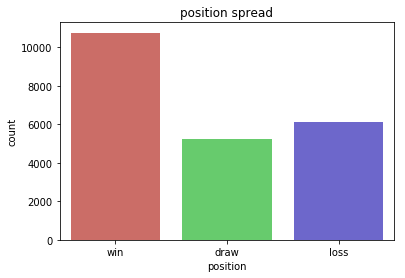

In [45]:
sns.countplot(x='position',data=final, palette='hls')
plt.title('position spread')
plt.xlabel('position')
plt.ylabel('count')

from the above plot we see that our data is imbalanced. more wins were captured compared to the draws and loss

Text(0, 0.5, 'home_score')

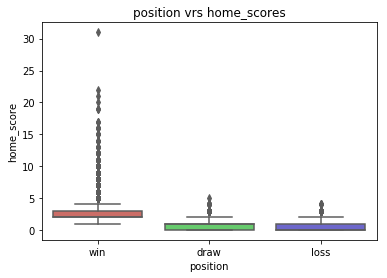

In [46]:
sns.boxplot(x='position', y='home_score', data=final, palette='hls')
plt.title('position vrs home_scores')
plt.xlabel('position')
plt.ylabel('home_score')

Here we see that a team scored more goals while at home

Text(0, 0.5, 'away_score')

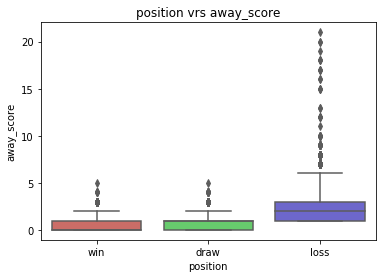

In [47]:
sns.boxplot(x='position', y='away_score', data=final, palette='hls')
plt.title('position vrs away_score')
plt.xlabel('position')
plt.ylabel('away_score')

we can say that it was likely for a team to lose while playing away

Text(0, 0.5, 'home_team_rank')

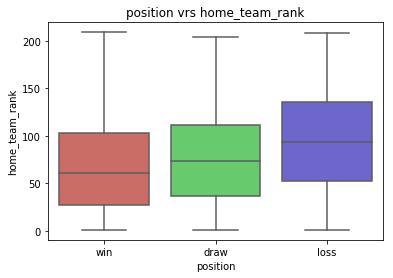

In [48]:
sns.boxplot(x='position', y='home_team_rank', data=final, palette='hls')
plt.title('position vrs home_team_rank')
plt.xlabel('position')
plt.ylabel('home_team_rank')

we see that as long as a team was loosing then the ranking fell

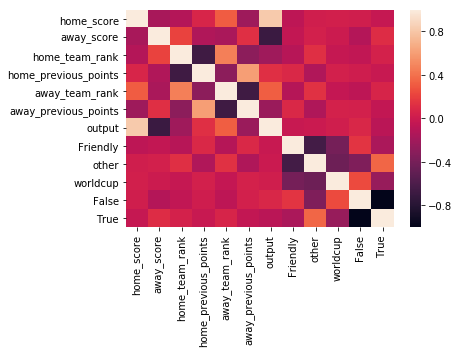

In [49]:
sns.heatmap(final.corr())

from the heat map above we can see that playing in a neutral ground influenced the friendly and worldcup matches but not other matches

# **Approach 1: Polynomial approach**

What to train given:

Rank of home team

Rank of away team

Tournament type

Model 1: Predict how many goals the home team scores

Model 2: Predict how many goals the away team scores

 

In [50]:
#from our final dataset we check if there are any missing values
final.isnull().sum()

home_score                 0
away_score                 0
home_team_rank          3454
home_previous_points    3454
away_team_rank          3545
away_previous_points    3545
output                     0
position                   0
Friendly                   0
other                      0
worldcup                   0
False                      0
True                       0
dtype: int64

In [0]:
#we drop the missing values
final.dropna(inplace=True)

# **Model 1 polynomial appraoch**

In [0]:
# our x value is Rank of home team and our y value is home team scores
X=final['home_team_rank'].values.reshape(-1,1)
y=final['home_score'].values



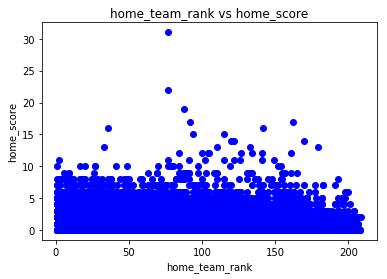

In [53]:
# Since our dataset is pretty clean, let's start by visualizing our dataset by plotting a scatter plot

plt.scatter(X, y, color='blue') 
plt.title('home_team_rank vs home_score')
plt.xlabel('home_team_rank')
plt.ylabel('home_score')
plt.show()

In [0]:
# Fit polynomial Regression to the dataset
poly_reg = PolynomialFeatures(degree = 10) 
X_poly = poly_reg.fit_transform(X)




In [55]:

pol_reg = LinearRegression()
pol_reg.fit(X_poly, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

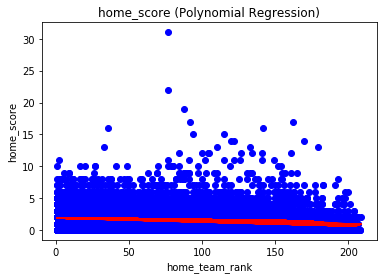

In [56]:
#Visualize the Polynomial Regression results
plt.scatter(X, y, color='blue') # You can put any color you like. This just helps us highlight the data points
plt.plot(X, pol_reg.predict(X_poly), color='red')
plt.title('home_score (Polynomial Regression)')
plt.xlabel('home_team_rank')
plt.ylabel('home_score')
plt.show()

when we increase our power the model shows no much change when using it on unseen data meaning for this dataset polynomial may not work in building a model

In [57]:
# Predict using Polynomial Regression
poly_pred = pol_reg.predict(poly_reg.fit_transform([[3]]))
print('Polynomial prediction: %d' %poly_pred)

Polynomial prediction: 1


from the prediction made by our polynomial model it obviously is not the best as its not very clear.it paints the correct picture though of the trend that as long as the rank is falling the scores are decreasing.

we will use a different model to challenge it.

# **Model 2 in Polynomial Approach**

In [0]:
X=final['away_team_rank'].values.reshape(-1,1)
y=final['away_score'].values

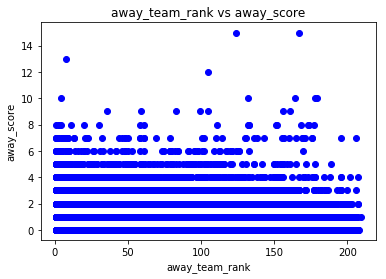

In [59]:
# Since our dataset is pretty clean, let's start by visualizing our dataset by plotting a scatter plot

plt.scatter(X, y, color='blue') 
plt.title('away_team_rank vs away_score')
plt.xlabel('away_team_rank')
plt.ylabel('away_score')
plt.show()

In [0]:
# Fit polynomial Regression to the dataset
poly_reg = PolynomialFeatures(degree = 10) 
X_poly = poly_reg.fit_transform(X)


In [61]:
pol_reg = LinearRegression()
pol_reg.fit(X_poly, y)



LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

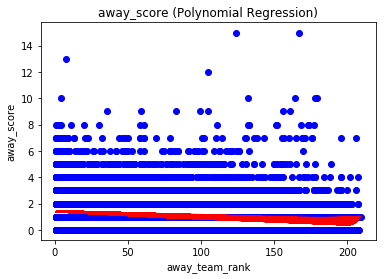

In [62]:
#Visualize the Polynomial Regression results
plt.scatter(X, y, color='blue') # You can put any color you like. This just helps us highlight the data points
plt.plot(X, pol_reg.predict(X_poly), color='red')
plt.title('away_score (Polynomial Regression)')
plt.xlabel('away_team_rank')
plt.ylabel('away_score')
plt.show()

In [63]:
# Predict using Polynomial Regression
poly_pred = pol_reg.predict(poly_reg.fit_transform([[50]]))
print('Polynomial prediction: %d' %poly_pred)

Polynomial prediction: 1


from the prediction made by our polynomial model it obviously is not the best as its not very clear.it paints the correct picture though of the trend that as long as the rank is falling the scores are decreasing.

we will use a different model to challenge it.

In [0]:
#Evaluation of the models
#think of RMSE
#Accuracy  score

# **Logistic Regression**

In [65]:
final.isnull().sum()

home_score              0
away_score              0
home_team_rank          0
home_previous_points    0
away_team_rank          0
away_previous_points    0
output                  0
position                0
Friendly                0
other                   0
worldcup                0
False                   0
True                    0
dtype: int64

In [0]:
#we now want to perform log regression but first get our independent variables, then check for multicollinearity to help identify the feature we shall 
#include in our model
#we want to figure out from the home team’s perspective if the game is a Win, Lose or Draw (W, L, D)
#we shall exclude home_score and away_scores from our dataset.
#our response variable will be position and the rest will be indep variables save for home and away scores
#y=final['position']
independent=final.drop(columns=['position','home_score','away_score','output'], axis=1)

In [67]:
correlation = independent.corr()
correlation

,home_team_rank,home_previous_points,away_team_rank,away_previous_points,Friendly,other,worldcup,False,True
home_team_rank,1.000000,-0.662370,0.467934,-0.293816,-0.096618,0.115546,-0.021925,-0.042665,0.042665
home_previous_points,-0.662370,1.000000,-0.290068,0.601588,0.081644,-0.118354,0.042324,0.010275,-0.010275
away_team_rank,0.467934,-0.290068,1.000000,-0.666422,-0.096785,0.128841,-0.037005,-0.052771,0.052771
away_previous_points,-0.293816,0.601588,-0.666422,1.000000,0.079581,-0.127964,0.055728,0.032181,-0.032181
Friendly,-0.096618,0.081644,-0.096785,0.079581,1.000000,-0.620451,-0.434102,0.096975,-0.096975
other,0.115546,-0.118354,0.128841,-0.127964,-0.620451,1.000000,-0.437159,-0.307578,0.307578
worldcup,-0.021925,0.042324,-0.037005,0.055728,-0.434102,-0.437159,1.000000,0.242102,-0.242102
False,-0.042665,0.010275,-0.052771,0.032181,0.096975,-0.307578,0.242102,1.000000,-1.000000
True,0.042665,-0.010275,0.052771,-0.032181,-0.096975,0.307578,-0.242102,-1.000000,1.000000


In [0]:
#Multicollinearity
#we have dropped all the variables and our multicollinearity code gave a result of our remaining variables being perfectly correlated and therefore
#gave an error

# Residual plots and heteroskedasticity **testing**

In [0]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
sklearn.metrics.mean_absolute_error

X = independent.values
y = final['position'].values

In [0]:
#splitting our dataset into train test split
#here we shall use cross validation
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
folds = KFold(n_splits=5)


In [71]:
# We now create and assess 5 models based on the folds we created.
RMSES = [] # We will use this array to keep track of the RSME of each model
count = 1 # This will just help 
for train_index, test_index in folds.split(X):
  print('\nTraining model ' + str(count))


Training model 1

Training model 1

Training model 1

Training model 1

Training model 1


In [0]:
# set up the train and test based on the split determined by KFold
  # With 5 folds, we will end up with 80% of our data in the training set, and 20% in the test set, just as above
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

In [73]:
#fit our model
LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
# Using our model to make a prediction
y_pred=LogReg.predict(X_test)



In [75]:
# Evaluating the model
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix


array([[   0,  271,  577],
       [   0,  542,  391],
       [   0,  203, 1394]])

In [76]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

        draw       0.00      0.00      0.00       848
        loss       0.53      0.58      0.56       933
         win       0.59      0.87      0.70      1597

    accuracy                           0.57      3378
   macro avg       0.37      0.48      0.42      3378
weighted avg       0.43      0.57      0.49      3378



from our confusion matrix the f1 score confirms that there are many false positives . to correct this we need more data and also to revise our assumptions incase the assumption ignored important information

# **Elastic Regression**

In [0]:
#import libraries for the different regressions
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn import linear_model



In [0]:
#fitting our ElasticNet into the data
elastic=ElasticNet(normalize=True)
search=GridSearchCV(estimator=elastic,param_grid={'alpha':np.logspace(-5,2,8),'l1_ratio':[.2,.4,.6,.8]},scoring='neg_mean_squared_error',n_jobs=1,refit=True,cv=10)

In [79]:
 data=pd.read_csv('final.csv')
 data.head()

,Unnamed: 0,home_score,away_score,home_team_rank,home_previous_points,away_team_rank,away_previous_points,output,position,Friendly,other,worldcup,False,True
0,0,3,1,59.0,13.0,22.0,47.0,2,win,0,0,1,1,0
1,1,1,1,8.0,55.0,14.0,42.0,0,draw,1,0,0,1,0
2,2,5,0,35.0,23.0,94.0,4.0,5,win,0,0,1,1,0
3,3,1,0,65.0,23.0,86.0,16.0,1,win,1,0,0,1,0
4,4,1,3,67.0,22.0,5.0,51.0,-2,loss,0,0,1,1,0


In [0]:
#we drop the unnamed column
data.drop('Unnamed: 0', axis=1, inplace=True)

In [81]:
#check whether this was done successfully
data.head()

,home_score,away_score,home_team_rank,home_previous_points,away_team_rank,away_previous_points,output,position,Friendly,other,worldcup,False,True
0,3,1,59.0,13.0,22.0,47.0,2,win,0,0,1,1,0
1,1,1,8.0,55.0,14.0,42.0,0,draw,1,0,0,1,0
2,5,0,35.0,23.0,94.0,4.0,5,win,0,0,1,1,0
3,1,0,65.0,23.0,86.0,16.0,1,win,1,0,0,1,0
4,1,3,67.0,22.0,5.0,51.0,-2,loss,0,0,1,1,0


In [82]:
#check the relationship of the independent variables
data.corr()

,home_score,away_score,home_team_rank,home_previous_points,away_team_rank,away_previous_points,output,Friendly,other,worldcup,False,True
home_score,1.000000,-0.165633,-0.111459,0.071770,0.314647,-0.213192,0.824076,-0.063397,0.029706,0.039043,0.024770,-0.024770
away_score,-0.165633,1.000000,0.216460,-0.130293,-0.159829,0.128714,-0.695149,-0.044628,0.040229,0.004260,-0.111596,0.111596
home_team_rank,-0.111459,0.216460,1.000000,-0.665694,0.467934,-0.293816,-0.204480,-0.099909,0.125291,-0.030183,-0.049759,0.049759
home_previous_points,0.071770,-0.130293,-0.665694,1.000000,-0.290068,0.601588,0.126550,0.087013,-0.126728,0.046755,0.018749,-0.018749
away_team_rank,0.314647,-0.159829,0.467934,-0.290068,1.000000,-0.667797,0.321075,-0.108597,0.139469,-0.036288,-0.066359,0.066359
away_previous_points,-0.213192,0.128714,-0.293816,0.601588,-0.667797,1.000000,-0.229293,0.087499,-0.133662,0.053916,0.041770,-0.041770
output,0.824076,-0.695149,-0.204480,0.126550,0.321075,-0.229293,1.000000,-0.020577,-0.001454,0.026013,0.082158,-0.082158
Friendly,-0.063397,-0.044628,-0.099909,0.087013,-0.108597,0.087499,-0.020577,1.000000,-0.647504,-0.400732,0.154514,-0.154514
other,0.029706,0.040229,0.125291,-0.126728,0.139469,-0.133662,-0.001454,-0.647504,1.000000,-0.438722,-0.357708,0.357708
worldcup,0.039043,0.004260,-0.030183,0.046755,-0.036288,0.053916,0.026013,-0.400732,-0.438722,1.000000,0.247854,-0.247854


there is a weak relationship between the independent variables. from this t looks like ridge regression will yield the best model.

In [83]:
data.columns

Index(['home_score', 'away_score', 'home_team_rank', 'home_previous_points',
       'away_team_rank', 'away_previous_points', 'output', 'position',
       'Friendly', 'other', 'worldcup', 'False', 'True'],
      dtype='object')

In [84]:
#from the previous deductions we learnt that scores dont influence the rank of any given team but
#previous points do as well as whether a team recorded a win,lose or draw influenced the ranking
#so we shall use oly the two columns to make our predictions
predictors =data [['home_team_rank','output','home_previous_points']]
predictors.head()

,home_team_rank,output,home_previous_points
0,59.0,2,13.0
1,8.0,0,55.0
2,35.0,5,23.0
3,65.0,1,23.0
4,67.0,-2,22.0


In [85]:
#we check whether there are missing values
predictors.isnull().sum()

home_team_rank          3454
output                     0
home_previous_points    3454
dtype: int64

In [0]:
#we drop the missing values
predictors.dropna(inplace=True)

In [0]:
#we separate our variables into a target and predictor variables
X=predictors.drop('home_team_rank', axis=1)
y=predictors['home_team_rank']

In [88]:
# Creating our linear regression model for the purpose of comparison(its going to be our baseline)
# 
regression=LinearRegression()
regression.fit(X,y)
first_model=(mean_squared_error(y_true=y,y_pred=regression.predict(X)))
print(first_model) 

# This mean standard error score of 1421.710 is our benchmark for determining 
# if the elastic net model will be better or worst. 

1421.7107985380173


In [89]:
# Below are the coefficients of this first model. We use a for loop to go through 
# the model and the zip function to combine the two columns.
# 
coef_dict_baseline = {}
for coef, feat in zip(regression.coef_,X.columns):
    coef_dict_baseline[feat] = coef
coef_dict_baseline

{'home_previous_points': -0.1057253768146687, 'output': -2.7960531821276686}

In [0]:
# Elastic Net Model
# Elastic net, just like ridge and lasso regression, requires normalize data.  
# This argument  is set inside the ElasticNet function. 
# The second thing we need to do is create our grid.
# 
elastic=ElasticNet(normalize=True)
search=GridSearchCV(estimator=elastic,param_grid={'alpha':np.logspace(-5,2,8),'l1_ratio':[.2,.4,.6,.8]},scoring='neg_mean_squared_error',n_jobs=1,refit=True,cv=10)

In [91]:
# We will now fit our model and display the best parameters and the best results we can get with that setup.
# 
search.fit(X,y)
search.best_params_
abs(search.best_score_)

1701.6833838391656

In [92]:
# The best hyperparameters was an alpha set to 0.001 and a l1_ratio of 0.8. 
# With these settings we got an MSE of 1701.683. This is above our baseline model of MSE 1421.710  for the baseline model. 
# Which means that elastic net is doing worse than linear regression. 
# For clarity, we will set our hyperparameters to the recommended values and run on the data.
# 
elastic=ElasticNet(normalize=True,alpha=0.001,l1_ratio=0.75)
elastic.fit(X,y)
second_model=(mean_squared_error(y_true=y,y_pred=elastic.predict(X)))
print(second_model)

2221.2902616916663


this worsen further so elastic regression not the best

In [93]:
# Below are the coefficients
# 
coef_dict_baseline = {}
for coef, feat in zip(elastic.coef_,X.columns):
    coef_dict_baseline[feat] = coef
coef_dict_baseline
# The coefficients are mostly the same. 
# This means that this values was no good to the algorithm. Traditional regression cannot do this.

{'home_previous_points': -0.018929775234945094, 'output': -0.7583806855479241}

we can conclude that elastic regression has not done any good to our model as the MSE is even greater than the baseline set.

# **RIDGE REGRESSION**

In [0]:
#We already have our baseline as a linear regression
#we fit the values in a ridge regression and we get the output and compare
ridge = Ridge(normalize=True)
search = GridSearchCV(estimator=ridge,param_grid={'alpha':np.logspace(-5,2,8)},scoring='neg_mean_squared_error',n_jobs=1,refit=True,cv=10)

In [95]:
# We now use the .fit function to run the model and then use the .best_params_ and
#  .best_scores_ function to determine the models strength. 
# 
search.fit(X,y)
search.best_params_
abs(search.best_score_) 


1707.4424745099523

In [96]:
# We can confirm this by fitting our model with the ridge information and finding the mean squared error below
#
ridge = Ridge(normalize=True,alpha=0.01)
ridge.fit(X,y)
second_model = (mean_squared_error(y_true=y,y_pred=ridge.predict(X)))
print(second_model)

1421.8199356892392


The ridge regression has fit our data better than the elastic regression.the RMSE is around the same figure as the baseline set.

In [97]:
# The 0.35 is lower than the 0.38. This is because the last results are not cross-validated. 
# In addition, these results indicate that there is little difference between the ridge and baseline models. 
# This is confirmed with the coefficients of each model found below.
# 
coef_dict_baseline = {}
for coef, feat in zip(regression.coef_,X.columns):
    coef_dict_baseline[feat] = coef
coef_dict_baseline

# The coefficient values are about the same. This means that the penalization made little difference with this dataset.

{'home_previous_points': -0.1057253768146687, 'output': -2.7960531821276686}

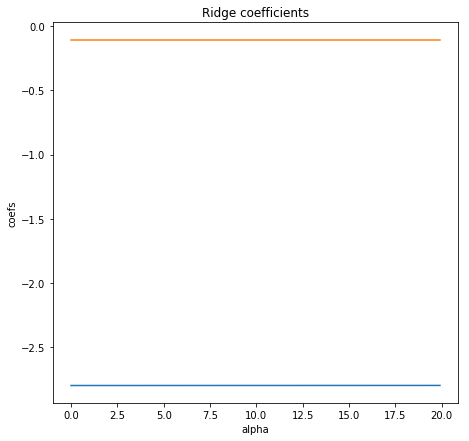

In [98]:
# Importing library for visualization
#
import matplotlib.pyplot as plt
coefsRidge = [] 

# Building Lasso for 200 values of alpha and write the coefficients into array
# 
alphasRidge = np.arange (0, 20, 0.1) 
for i in range(200):
    ridge = linear_model.Ridge(alpha=alphasRidge[i])
    ridge.fit(X, y)
    coefsRidge.append(ridge.coef_) 

# Building Ridge coefficient plots
# 
plt.figure(figsize = (16,7))

plt.subplot(121)
plt.plot(alphasRidge, coefsRidge)
plt.title('Ridge coefficients')
plt.xlabel('alpha')
plt.ylabel('coefs')

plt.show()


The ridge regression will penalize your coefficients, such that those who are the least efficient in your estimation will "shrink" the fastest.We can therfore say that the variable represented by the orange line shrunk faster and is less efficient to the variable rep by the blue line.

# **LASSO REGRESSION**

In [0]:
#We note that for lasso we begin by scaling the data.because it has the 
#ability to select features we shall plug in all the feature and see the outcome 
# Lasso put constraints on the size of the coefficients associated to each variable. 
# But, this value depends on the magnitude of each variable and it is therefore 
# necessary to center and reduce, or standardize, the variables.
# 

# Importing StandardScaler
#
from sklearn.preprocessing import StandardScaler
predictor_lasso =data[['home_score', 'away_score', 'home_team_rank', 'home_previous_points',
       'away_team_rank', 'away_previous_points', 'output', 'position',
       'Friendly', 'other', 'worldcup', 'False', 'True']]


In [100]:
#we check for missing values
predictor_lasso.isnull().sum()

home_score                 0
away_score                 0
home_team_rank          3454
home_previous_points    3454
away_team_rank          3545
away_previous_points    3545
output                     0
position                   0
Friendly                   0
other                      0
worldcup                   0
False                      0
True                       0
dtype: int64

In [0]:
predictor_lasso.dropna(inplace=True)

In [102]:
#we check whether the null values dropped 
predictor_lasso.isnull().sum()

home_score              0
away_score              0
home_team_rank          0
home_previous_points    0
away_team_rank          0
away_previous_points    0
output                  0
position                0
Friendly                0
other                   0
worldcup                0
False                   0
True                    0
dtype: int64

In [0]:
# Creating features and target matrixes
X=predictor_lasso.drop(['home_team_rank','position'],axis=1)
y=predictor_lasso['home_team_rank']

In [0]:
# Scaling data 
#
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [0]:
#Creating lasso object
lasso = linear_model.Lasso()



In [112]:
X.shape

(16890, 11)

In [113]:
y.shape

(16890,)

In [114]:
# Fitting the models
# 
lasso.fit(X, y) 


Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [115]:
# Print scores, MSE, and coefficients
# 
print("lasso score:", lasso.score(X, y)) 
print("lasso MSE:", mean_squared_error(y, lasso.predict(X))) 
print("lasso coef:", lasso.coef_) 

lasso score: 0.7241026351512362
lasso MSE: 712.1889943208992
lasso coef: [ -0.           1.14063365 -37.27862255  32.48895504  25.75392904
  -9.37613199  -0.           0.           0.           0.
  -0.        ]


we can see that lasso regression can actually select feature because it has reduced some coefficient varibles to zero meaning they are not important for our modelling

In [0]:
# Splitting the data into training and test sets, building Lasso, 
# and choosing the regularization parameter with the help of GridSearch. 
# For that, we have to define the set of parameters for GridSearch. 
# In this case, a model with the highest R-squared score will give us the best parameters.
# 

# Making necessary imports, split data into training and test sets, and choose a set of parameters 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)
parameters = {'alpha': np.concatenate((np.arange(0.1,2,0.1), np.arange(2, 5, 0.5), np.arange(5, 25, 1)))}

linear = linear_model.LinearRegression()
lasso = linear_model.Lasso() 
gridlasso = GridSearchCV(lasso, parameters, scoring ='r2') 


In [117]:
# Fitting models and print the best parameters, R-squared scores, MSE, and coefficients
gridlasso.fit(X_train, y_train) 
linear.fit(X_train, y_train) 
print("lasso best parameters:", gridlasso.best_params_) 
print("lasso score:", gridlasso.score(X_test, y_test))
print("linear score:", linear.score(X_test, y_test)) 
print("lasso MSE:", mean_squared_error(y_test, gridlasso.predict(X_test)))
print("linear MSE:", mean_squared_error(y_test, linear.predict(X_test))) 
print("lasso best estimator coef:", gridlasso.best_estimator_.coef_)
print("linear coef:", linear.coef_)

lasso best parameters: {'alpha': 0.1}
lasso score: 0.722975032301479
linear score: 0.7227427161837637
lasso MSE: 709.4563090662209
linear MSE: 710.05126675823
lasso best estimator coef: [-0.00000000e+00  1.29427682e+00 -3.98752470e+01  3.61310784e+01
  3.04560831e+01 -1.00762689e+01 -7.88552243e-01  0.00000000e+00
  1.92193135e-01  5.80492268e-02 -4.46428220e-16]
linear coef: [ 4.32467838e+13 -3.33297165e+13 -4.01585693e+01  3.65273438e+01
  3.09316406e+01 -5.87592806e+13 -5.53843204e+12 -5.54754098e+12
 -4.82940096e+12 -2.12404517e+12 -2.12404517e+12]


we can see that lasso performs really really well as the MSE has reduced to 709 lesser than that of the baseline set of 1421. so our model has improved by almost 50%.

the lasso regression has also reduced some coefficients to zero showing its ability for feature selection.it has also shrunk the coefficient towards zero

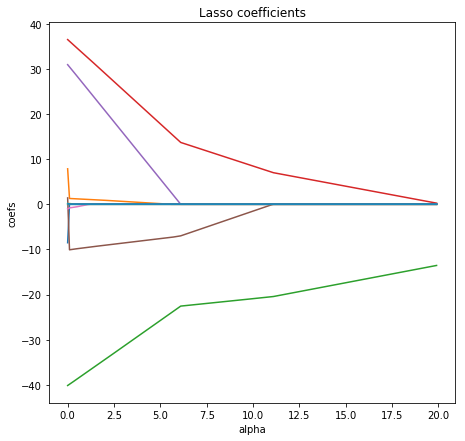

In [118]:
# Importing library for visualization
#
import matplotlib.pyplot as plt
coefsLasso = [] 

# Building Lasso for 200 values of alpha and write the coefficients into array
# 
alphasLasso = np.arange (0, 20, 0.1) 
for i in range(200):
    lasso = linear_model.Lasso(alpha=alphasLasso[i])
    lasso.fit(X_train, y_train)
    coefsLasso.append(lasso.coef_) 

# Building Lasso coefficient plots
# 
plt.figure(figsize = (16,7))

plt.subplot(121)
plt.plot(alphasLasso, coefsLasso)
plt.title('Lasso coefficients')
plt.xlabel('alpha')
plt.ylabel('coefs')

plt.show()

# As we can see, Lasso influences less on the large coefficients, but the small ones Lasso reduces to zeroes. 
# Therefore Lasso can also be used to determine which features are important 
# to us and keeps the features that may influence the target variable

From the above trace plot the variables that enter the model faster as the most efficient predictors.

In the plot above colored line represents the value taken by a different coefficient in our model. alpha is the weight given to the regularization term , so as alpha approaches zero, the loss function of our model approaches the OLS loss function

Therefore, when alpha is very small, the LASSO solution should be very close to the OLS solution, and all of our coefficients are in the model. As alpha grows, the regularization term has greater effect and we will see fewer variables in your model